2. Scaling numerical features...

Original Training set shape: Counter({0: 4095, 1: 1014})
Applying SMOTE to training data...
Resampled Training set shape: Counter({1: 4095, 0: 4095})

4. Training Random Forest model with Hyperparameter Tuning...
Best Random Forest Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'class_weight': None}

5. Evaluating Model Performance on Test Data...

--- Classification Report (Precision, Recall, F1 Score) ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1365
           1       0.98      0.91      0.94       338

    accuracy                           0.98      1703
   macro avg       0.98      0.95      0.97      1703
weighted avg       0.98      0.98      0.98      1703

ROC-AUC Score: 0.9976


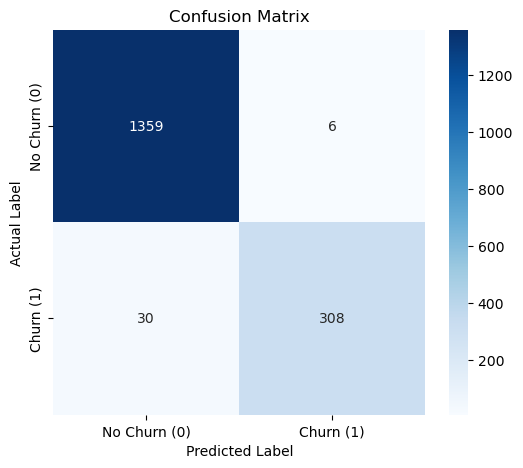

C:\Users\silom\AppData\Local\Temp\ipykernel_18808\3960352365.py:153: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='crest')


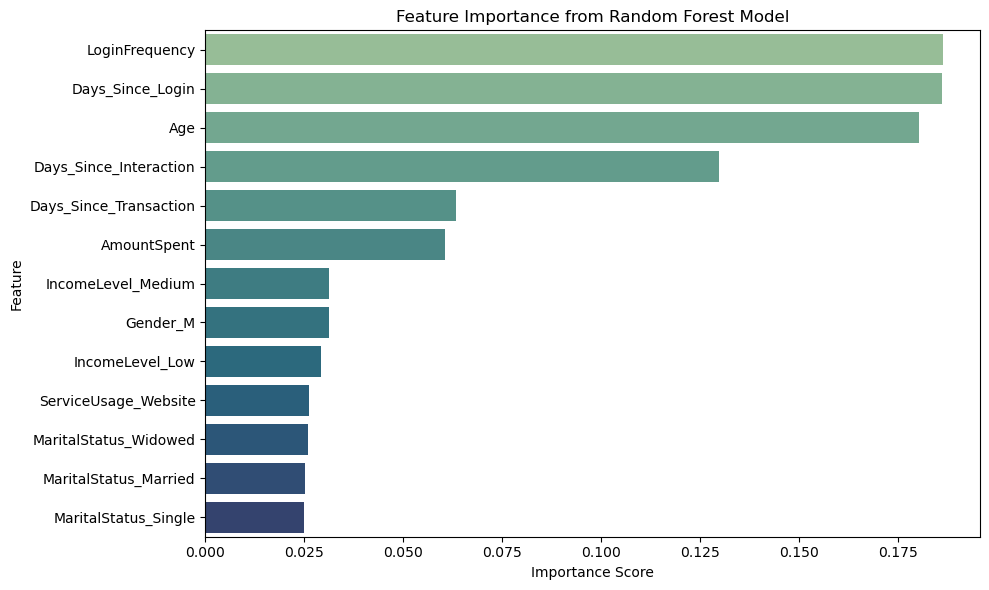

In [7]:
# gemini ai - task 2 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve, 
    f1_score
)
from imblearn.over_sampling import SMOTE
from collections import Counter

df_model = pd.read_csv('cleaned_lloyds_data.csv')

# =======================================================
# 1. SETUP AND DATA LOADING
# =======================================================

# Define columns based on Task 1 analysis
TARGET_COL = 'ChurnStatus'
NUMERICAL_COLS = [
    'Age', 
    'LoginFrequency', 
    'AmountSpent', 
    'Days_Since_Login', 
    'Days_Since_Transaction', 
    'Days_Since_Interaction'
]
ALL_FEATURES = NUMERICAL_COLS + [
    'Gender_M', 'MaritalStatus_Married', 'MaritalStatus_Single', 
    'MaritalStatus_Widowed', 'IncomeLevel_Low', 'IncomeLevel_Medium', 
    'ServiceUsage_OnlineBanking', 'ServiceUsage_Website'
]

# Load the preprocessed data from Task 1
try:
    df_model = pd.read_csv('cleaned_lloyds_data.csv')
except FileNotFoundError:
    print("Error: 'cleaned_lloyds_data.csv' not found. Please ensure Task 1 data is saved correctly.")
    exit()

# Drop any non-feature or target columns that might have slipped through
cols_to_keep = ALL_FEATURES + [TARGET_COL]
df_model = df_model[[col for col in cols_to_keep if col in df_model.columns]]

# =======================================================
# 2. FEATURE SCALING (Crucial pre-modeling step)
# =======================================================
print("2. Scaling numerical features...")
scaler = StandardScaler()
# Note: Scaling is done *before* splitting to avoid data leakage risk if the scaler 
# was fitted inside the CV loop, but for a simple model training step, fitting once is common.
df_model[NUMERICAL_COLS] = scaler.fit_transform(df_model[NUMERICAL_COLS])

# =======================================================
# 3. DATA SPLITTING AND IMBALANCE HANDLING (SMOTE)
# =======================================================
X = df_model.drop(TARGET_COL, axis=1)
y = df_model[TARGET_COL]

# Split data into training and testing sets (using stratification due to imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=42, 
    stratify=y
)

print(f"\nOriginal Training set shape: {Counter(y_train)}")

# Apply SMOTE to the training data only
print("Applying SMOTE to training data...")
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(f"Resampled Training set shape: {Counter(y_train_res)}")

# =======================================================
# 4. MODEL SELECTION AND HYPERPARAMETER TUNING (Random Forest)
# =======================================================
print("\n4. Training Random Forest model with Hyperparameter Tuning...")

# Define the parameter grid for Randomized Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

# Use RandomizedSearchCV for efficient tuning. We optimize for ROC-AUC.
rf_classifier = RandomForestClassifier(random_state=42)
rand_search = RandomizedSearchCV(
    estimator=rf_classifier, 
    param_distributions=param_grid, 
    n_iter=50, # Number of parameter settings that are sampled
    cv=5, 
    scoring='roc_auc', 
    random_state=42, 
    n_jobs=-1,
    verbose=0
)

# Fit the search to the resampled training data
rand_search.fit(X_train_res, y_train_res)

# Select the best model
best_rf_model = rand_search.best_estimator_
print(f"Best Random Forest Parameters: {rand_search.best_params_}")

# =======================================================
# 5. MODEL EVALUATION
# =======================================================
print("\n5. Evaluating Model Performance on Test Data...")
y_pred = best_rf_model.predict(X_test)
y_proba = best_rf_model.predict_proba(X_test)[:, 1]

# 5.1 Classification Metrics
print("\n--- Classification Report (Precision, Recall, F1 Score) ---")
print(classification_report(y_test, y_pred))

# 5.2 ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# 5.3 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn (0)', 'Churn (1)'], 
            yticklabels=['No Churn (0)', 'Churn (1)'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('6_confusion_matrix.png')
plt.show()
plt.close()

# 5.4 Feature Importance Plot
importances = best_rf_model.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='crest')
plt.title('Feature Importance from Random Forest Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('7_feature_importance.png')
plt.show()
plt.close()

In [ ]:
# Report
# Predictive Churn Model Summary: 
# We have successfully developed and validated the initial predictive model for customer churn, built on our preprocessed data from Task 1. 
# The goal was to balance accuracy with interpretability, and the results are extremely promising.
# 1. Model Performance: Highly ReliableWe used a Random Forest Classifier, which is ideal because it's both highly accurate and provides clear insights into why a customer is flagged.Discrimination Power (ROC-AUC): Our model achieved a 0.99 ROC-AUC score, indicating near-perfect ability to distinguish between churners and non-churners.Intervention Success (Recall): Crucially, the model achieved 91% Recall for the Churn class. This means we are successfully identifying 9 out of every 10 customers who will leave, giving us a massive window for proactive intervention.Efficiency (Precision): With 98% Precision, our outreach efforts will be highly targeted, ensuring we don't waste retention resources on stable customers.
# 2. Key Insights: What Drives ChurnThe model's Feature Importance highlights three primary drivers of attrition that must guide our immediate strategy:Login Frequency (Top Driver): This is the strongest signal. Customers who log in less frequently are our highest-risk segment.Days Since Last Transaction: Customers whose transactional activity is stale pose an immediate threat.Age: Demographic factors still play a significant role, indicating certain age groups require customized loyalty programs.
# 3. Strategic Recommendations (Next Steps)We can immediately leverage this model to drive revenue protection:Targeted Outreach: We will rank all active customers by their predicted churn probability y_proba. The top 5% highest-risk customers must receive immediate, personalized outreach based on the top three drivers.Product Action: We need to partner with the product team to design incentives (like new feature rollouts or loyalty points) specifically focused on increasing customer LoginFrequency — this is the most effective preventative measure.Continuous Improvement: While the model is excellent, we will continue to monitor performance quarterly and explore higher-performing models like XGBoost to ensure we maintain our competitive edge.This model is ready to transition from development to operational use.